Given the loan default dataset, apply the following algorithms to find the best ensemble classifier:

1. Random Forest
2. AdaBoost 

Author: Carlos Caballero
Data Scientist

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

In [2]:
#Download data
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-09-27 14:15:23--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.001s  

2019-09-27 14:15:23 (14.8 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


In [6]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'loan_status', 'Principal', 'terms',
       'effective_date', 'due_date', 'age', 'education', 'Gender'],
      dtype='object')

In [7]:
# Dropped first two columns, will not be needed later for training
df = df.drop(df.columns[[0, 1]], axis=1)
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


## Data exploration and pre-processing



In [8]:
df.describe()

,Principal,terms,age
count,346.000000,346.000000,346.000000
mean,943.641618,22.653179,30.939306
std,109.425530,7.991006,6.039418
min,300.000000,7.000000,18.000000
25%,900.000000,15.000000,27.000000
50%,1000.000000,30.000000,30.000000
75%,1000.000000,30.000000,35.000000
max,1000.000000,30.000000,51.000000


In [9]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

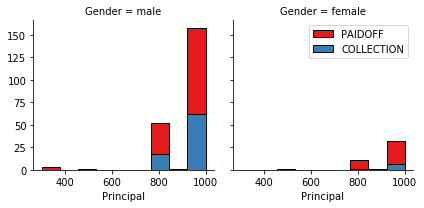

In [10]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

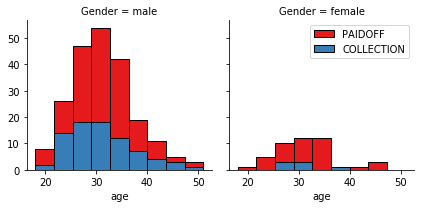

In [11]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

### Lets look at the day of the week people get the loan 

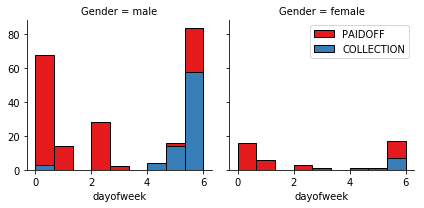

In [12]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


I see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [13]:
# Assign numerical values to existing categorical features

df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


Lets look at gender:

In [14]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


In [15]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

There's type in education column

In [16]:
# Convert 'female' and 'male' to 0 and 1 values
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


In [17]:
# Fix typo
df['education'].replace(to_replace=['Bechalor'], value=['Bachelor'],inplace=True)
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bachelor,1,3,0
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


In [18]:
# Minor change
df['education'].replace(to_replace=['Master or Above'], value=['Graduate'],inplace=True)
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bachelor,1,3,0
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


In [19]:
# Making change for more clarity
df['education'].replace(to_replace=['college'], value=['some_college'],inplace=True)
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bachelor,1,3,0
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,some_college,0,3,0
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,some_college,1,4,1
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,some_college,0,4,1


In [20]:
# Try grouping again after fixing type in education column after making changes
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bachelor              PAIDOFF        0.750000
                      COLLECTION     0.250000
Graduate              COLLECTION     0.500000
                      PAIDOFF        0.500000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
some_college          PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

## One Hot Encoding  

#### Feature before One Hot Encoding

In [21]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bachelor
2,1000,15,27,0,some_college
3,1000,30,28,1,some_college
4,1000,30,29,0,some_college


## One hot encode 

In [22]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.head()


,Principal,terms,age,Gender,weekend,Bachelor,Graduate,High School or Below,some_college
0,1000,30,45,0,0,0,0,1,0
1,1000,30,33,1,0,1,0,0,0
2,1000,15,27,0,0,0,0,0,1
3,1000,30,28,1,1,0,0,0,1
4,1000,30,29,0,1,0,0,0,1


### Feature selection for modeling

In [23]:
X_train = Feature
X_train[0:5]

,Principal,terms,age,Gender,weekend,Bachelor,Graduate,High School or Below,some_college
0,1000,30,45,0,0,0,0,1,0
1,1000,30,33,1,0,1,0,0,0
2,1000,15,27,0,0,0,0,0,1
3,1000,30,28,1,1,0,0,0,1
4,1000,30,29,0,1,0,0,0,1


In [24]:
y_train = df['loan_status'].values
y_train[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [25]:
X_train= preprocessing.StandardScaler().fit(X_train).transform(X_train)
X_train[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062, -0.07624929,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.07624929, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.07624929, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.07624929, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.07624929, -0.87997669,  1.14984679]])

# Classification 

As mentioned above, I will use the following algorithms:

- Random Forest
- Boosted Tree


## Train the classifiers

### Random Forest


In [26]:
from sklearn.ensemble import RandomForestClassifier

In [27]:
forest_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=16,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [36]:
feature_importances = pd.DataFrame(forest_clf.feature_importances_,
                                   index = Feature.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
print(feature_importances)

                      importance
weekend                 0.474111
age                     0.271269
terms                   0.076313
Gender                  0.046403
Principal               0.038386
High School or Below    0.030316
some_college            0.029205
Bachelor                0.025282
Graduate                0.008716


In [56]:
# Modify training set based on feature imporance output

Feature = df[['terms','age','Gender','weekend']]
#Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.head()


,terms,age,Gender,weekend
0,30,45,0,0
1,30,33,1,0
2,15,27,0,0
3,30,28,1,1
4,30,29,0,1


In [57]:
X_train = Feature
X_train[:5]

,terms,age,Gender,weekend
0,30,45,0,0
1,30,33,1,0
2,15,27,0,0
3,30,28,1,1
4,30,29,0,1


In [58]:
# Retrain RF model with modified features

forest_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=16,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Adaboost

In [59]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [60]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200, algorithm="SAMME.R", learning_rate=0.5)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=None)

In [61]:
feature_importances = pd.DataFrame(ada_clf.feature_importances_,
                                   index = Feature.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
print(feature_importances)

         importance
age           0.895
weekend       0.050
terms         0.030
Gender        0.025


# Model Evaluation using Test set

In [62]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [63]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-09-27 14:47:00--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2019-09-27 14:47:00 (409 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [64]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [65]:
# Dropped first two columns, will not be needed later for training
test_df = test_df.drop(test_df.columns[[0, 1]], axis=1)
test_df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [66]:
test_df.shape

(54, 8)

In [67]:
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,1
1,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,0
2,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,1
3,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,0
4,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,0


In [68]:
# Fix typo
test_df['education'].replace(to_replace=['Bechalor'], value=['Bachelor'],inplace=True)
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bachelor,1,3,0
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,some_college,0,3,0
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,some_college,1,4,1
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,some_college,0,4,1


In [69]:
# Minor change
test_df['education'].replace(to_replace=['Master or Above'], value=['Graduate'],inplace=True)
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bachelor,1,3,0
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,some_college,0,3,0
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,some_college,1,4,1
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,some_college,0,4,1


In [70]:
# Making change for more clarity
test_df['education'].replace(to_replace=['college'], value=['some_college'],inplace=True)
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bachelor,1,3,0
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,some_college,0,3,0
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,some_college,1,4,1
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,some_college,0,4,1


In [71]:
test_df['dayofweek'] = df['effective_date'].dt.dayofweek

In [72]:
test_df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bachelor,1,3,0
1,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Graduate,0,3,0
2,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,1,3,0
3,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,some_college,0,4,1
4,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bachelor,0,4,1


In [73]:
test_df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
0       PAIDOFF        0.744186
        COLLECTION     0.255814
1       PAIDOFF        0.727273
        COLLECTION     0.272727
Name: loan_status, dtype: float64

In [74]:
test_df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bachelor              PAIDOFF        1.000000
Graduate              PAIDOFF        1.000000
High School or Below  PAIDOFF        0.523810
                      COLLECTION     0.476190
some_college          PAIDOFF        0.826087
                      COLLECTION     0.173913
Name: loan_status, dtype: float64

In [75]:
test_df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,50,1,Bachelor
1,300,7,35,0,Graduate
2,1000,30,43,1,High School or Below
3,1000,30,26,0,some_college
4,800,15,29,0,Bachelor


In [82]:
# One-hot-encode test set
test_feature = test_df[['terms','age','Gender','weekend']]
#test_feature = pd.concat([test_feature,pd.get_dummies(test_df['education'])], axis=1)
#test_feature.drop(['Graduate'], axis = 1,inplace=True)
test_feature.head()


,terms,age,Gender,weekend
0,30,50,1,0
1,7,35,0,0
2,30,43,1,0
3,30,26,0,1
4,15,29,0,1


In [83]:
X_test = test_feature
X_test[0:5]

,terms,age,Gender,weekend
0,30,50,1,0
1,7,35,0,0
2,30,43,1,0
3,30,26,0,1
4,15,29,0,1


In [84]:
y_test = test_df['loan_status'].values
y_test[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [85]:
# Import confusion matrix to evaluate performance
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [86]:
# Function to plot confusion matrix and normalize data if necessary by setting it to "true"
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Random Forest Evaluation

In [87]:
# Make predictions
yhat_rf = forest_clf.predict(X_test)
yhat_rf [0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [88]:
# Check accuracy of model
from sklearn import metrics
print("Training Accuracy: ","%.2f" % metrics.accuracy_score(y_train, forest_clf.predict(X_train)))
print("Test Accuracy: ","%.2f" % metrics.accuracy_score(y_test, yhat_rf))

Training Accuracy:  0.80
Test Accuracy:  0.70


In [89]:
# Calculate Jaccard Index
from sklearn.metrics import jaccard_similarity_score
print("Jaccard coeficient: ","%.2f" %jaccard_similarity_score(y_test, yhat_rf))

Jaccard coeficient:  0.70


In [90]:
# See F1 score
from sklearn.metrics import f1_score
print("Avg F1-score: %.2f" % f1_score(y_test, yhat_rf, average='weighted'))

Avg F1-score: 0.64


              precision    recall  f1-score   support

  COLLECTION       0.25      0.07      0.11        14
     PAIDOFF       0.74      0.93      0.82        40

   micro avg       0.70      0.70      0.70        54
   macro avg       0.49      0.50      0.47        54
weighted avg       0.61      0.70      0.64        54

Confusion matrix, without normalization
[[ 1 13]
 [ 3 37]]


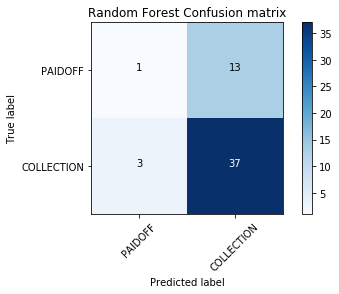

In [91]:
# Compute confusion matrix
cnf_matrix_rf = confusion_matrix(y_test, yhat_rf)
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat_rf))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_rf, classes=["PAIDOFF", "COLLECTION"],normalize= False,  title='Random Forest Confusion matrix')

## AdaBoost evaluation

In [92]:
#Prediction
yhat_boost = ada_clf.predict(X_test)

In [93]:
# Compare prediction and actual results
print (yhat_boost [0:5])
print (y_test [0:5])

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


In [94]:
# Check accuracy of model
from sklearn import metrics
print("Training Accuracy: ","%.2f" % metrics.accuracy_score(y_train, ada_clf.predict(X_train)))
print("Test Accuracy: ","%.2f" % metrics.accuracy_score(y_test, yhat_boost))

Training Accuracy:  0.74
Test Accuracy:  0.56


In [95]:
# Evaluation
from sklearn import metrics
import matplotlib.pyplot as plt
print("AdaBoost's Accuracy: ", metrics.accuracy_score(y_test, yhat_boost))

AdaBoost's Accuracy:  0.5555555555555556


In [96]:
# Calculate Jaccard Index
from sklearn.metrics import jaccard_similarity_score
print("Jaccard coeficient: ","%.2f" %jaccard_similarity_score(y_test, yhat_boost))

Jaccard coeficient:  0.56


In [97]:
# See F1 score
from sklearn.metrics import f1_score
print("Avg F1-score: %.2f" % f1_score(y_test, yhat_boost, average='weighted'))

Avg F1-score: 0.56


              precision    recall  f1-score   support

  COLLECTION       0.19      0.21      0.20        14
     PAIDOFF       0.71      0.68      0.69        40

   micro avg       0.56      0.56      0.56        54
   macro avg       0.45      0.44      0.45        54
weighted avg       0.57      0.56      0.56        54

Confusion matrix, without normalization
[[ 3 11]
 [13 27]]


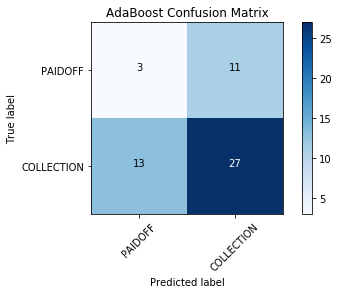

In [98]:
# Compute confusion matrix
cnf_matrix_boost = confusion_matrix(y_test, yhat_boost)
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat_boost))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_boost, classes=["PAIDOFF", "COLLECTION"],normalize= False,  title='AdaBoost Confusion Matrix')

# Report
Report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| Randfom Forest     |  0.70   |   0.64   |    NA   |
| AdaBoost           |  0.56   |   0.56   |    NA   |


Random Forest performed the best

## Final model output - Random Forest

In [102]:
rf_prob = forest_clf.predict_proba(X_test[:])
print(rf_prob)

[[0.04 0.96]
 [0.01 0.99]
 [0.03 0.97]
 [0.49 0.51]
 [0.44 0.56]
 [0.33 0.67]
 [0.46 0.54]
 [0.43 0.57]
 [0.52 0.48]
 [0.45 0.55]
 [0.46 0.54]
 [0.07 0.93]
 [0.41 0.59]
 [0.37 0.63]
 [0.37 0.63]
 [0.38 0.62]
 [0.26 0.74]
 [0.05 0.95]
 [0.38 0.62]
 [0.03 0.97]
 [0.42 0.58]
 [0.04 0.96]
 [0.09 0.91]
 [0.44 0.56]
 [0.38 0.62]
 [0.4  0.6 ]
 [0.39 0.61]
 [0.51 0.49]
 [0.38 0.62]
 [0.43 0.57]
 [0.43 0.57]
 [0.46 0.54]
 [0.43 0.57]
 [0.42 0.58]
 [0.46 0.54]
 [0.43 0.57]
 [0.4  0.6 ]
 [0.37 0.63]
 [0.4  0.6 ]
 [0.61 0.39]
 [0.38 0.62]
 [0.22 0.78]
 [0.58 0.42]
 [0.42 0.58]
 [0.49 0.51]
 [0.27 0.73]
 [0.38 0.62]
 [0.25 0.75]
 [0.42 0.58]
 [0.43 0.57]
 [0.44 0.56]
 [0.41 0.59]
 [0.46 0.54]
 [0.38 0.62]]


In [103]:
df_prob = pd.DataFrame(rf_prob)
df_prob.columns  = ['collection_prob','paidoff_prob']
np.asanyarray(df_prob[['collection_prob','paidoff_prob']])
df_prob.head()


,collection_prob,paidoff_prob
0,0.037682,0.962318
1,0.013555,0.986445
2,0.030857,0.969143
3,0.487554,0.512446
4,0.443674,0.556326


In [106]:
df_pred = pd.DataFrame(yhat_rf)
df_pred.columns  = ['prediction']
np.asanyarray(df_pred[['prediction']])

df_model_output = pd.merge(test_df,df_pred,how = 'left',left_index = True, right_index = True)

#Re-arrange columns
df_final = df_model_output[['Principal', 'terms', 'effective_date', 'due_date', 'age', 'education', 'Gender', 'dayofweek', 'weekend', 'loan_status', 'prediction']]
df_final.head(5)

,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend,loan_status,prediction
0,1000,30,9/8/2016,10/7/2016,50,Bachelor,1,3,0,PAIDOFF,PAIDOFF
1,300,7,9/9/2016,9/15/2016,35,Graduate,0,3,0,PAIDOFF,PAIDOFF
2,1000,30,9/10/2016,10/9/2016,43,High School or Below,1,3,0,PAIDOFF,PAIDOFF
3,1000,30,9/10/2016,10/9/2016,26,some_college,0,4,1,PAIDOFF,PAIDOFF
4,800,15,9/11/2016,9/25/2016,29,Bachelor,0,4,1,PAIDOFF,PAIDOFF


In [108]:
# Add probability scores to final data
df_final2 = pd.merge(df_final,df_prob,how = 'left',left_index = True, right_index = True)
df_final2.head(5)

,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend,loan_status,prediction,collection_prob,paidoff_prob
0,1000,30,9/8/2016,10/7/2016,50,Bachelor,1,3,0,PAIDOFF,PAIDOFF,0.037682,0.962318
1,300,7,9/9/2016,9/15/2016,35,Graduate,0,3,0,PAIDOFF,PAIDOFF,0.013555,0.986445
2,1000,30,9/10/2016,10/9/2016,43,High School or Below,1,3,0,PAIDOFF,PAIDOFF,0.030857,0.969143
3,1000,30,9/10/2016,10/9/2016,26,some_college,0,4,1,PAIDOFF,PAIDOFF,0.487554,0.512446
4,800,15,9/11/2016,9/25/2016,29,Bachelor,0,4,1,PAIDOFF,PAIDOFF,0.443674,0.556326


In [113]:
#Average probability of collection
print("The average COLLECTION probatility is", "%.2f" % np.mean(df_final2['collection_prob']))

The average COLLECTION probatility is 0.36


In [114]:
#Average probability of collection
print("The average PAIDOFF probatility is", "%.2f" % np.mean(df_final2['paidoff_prob']))

The average PAIDOFF probatility is 0.64


In [115]:
df_final2['collection_prob'].describe()

count    54.000000
mean      0.360140
std       0.148577
min       0.013555
25%       0.369123
50%       0.408402
75%       0.443674
max       0.611340
Name: collection_prob, dtype: float64

In [116]:
df_final2['paidoff_prob'].describe()

count    54.000000
mean      0.639860
std       0.148577
min       0.388660
25%       0.556326
50%       0.591598
75%       0.630877
max       0.986445
Name: paidoff_prob, dtype: float64

In [117]:
# Write to csv file
#df_final2.to_csv('tree_model.csv', encoding='utf-8', index=False)
df_final2.to_csv(r'C:\Users\carlos.caballero\Desktop\tree_model.csv', index=False) 